# Simple Embedded Fragments Example for Bulk Graphene 
Here we will generate a small graphene cell, setup and run a (very low accuracy) calculation and do some post-processing.  To keep things simple, the cell size stays the same between the read and write calculation.  There are two fragment types, CA and CB.

In [1]:
from BigDFT import Logfiles as lf
from BigDFT import Fragments as F
import numpy as np
import graphene

In [2]:
#generate the posinp
cell_dims,graphene_pos=graphene.build_graphene(5,3)
#print bcs
nat=len(graphene_pos)
F.dump_xyz(graphene_pos,basename='C',units='atomic',filename='graphene.xyz',position='w',cell=cell_dims)

In [4]:
templatesys=F.System(xyz='graphene.xyz',nat_reference=1)
templateA=templatesys.fragments[0]
templateA.set_id('CA')
templateB=templatesys.fragments[1]
templateB.set_id('CB')

# we don't actually need to .yaml files, just the .xyz in the correct directory
#F.prepare_fragment_inputs('CA','data-graphene',template=templateA)
#F.prepare_fragment_inputs('CB','data-graphene',template=templateB)

#print(len(templatesys.fragments))
#templatesys.CMs
#templatesys.decomposition

#fullsys=F.System(transformations=templatesys.decomposition)
#F.prepare_fragment_inputs('graphene','embedded',system=templatesys,template_dir='data-graphene',
#                          template_name='CA',flavour='Embedded')

Warning, line not parsed: " surface 23.0694 0.0 23.97438 # xyz dump with basename "C"
could not convert string to float: # "


In [5]:
# make sure we have the correct directories and posinps for the templates
#import shutil,os,yaml
from futile.Utils import ensure_dir
sysname='graphene'
sysdir='data-'+sysname
ensure_dir(sysdir)
ensure_dir(sysdir+'/data-'+templateA.id)
ensure_dir(sysdir+'/data-'+templateB.id)
F.dump_xyz([[0.0,0.0,0.0]],basename='C',units='atomic',filename=sysdir+'/CA.xyz',position='w')
F.dump_xyz([[0.0,0.0,0.0]],basename='C',units='atomic',filename=sysdir+'/CB.xyz',position='w')

In [6]:
# now create the yaml read and write files
from futile import Yaml as Y
write_dict=Y.load("write.yaml")
read_dict=Y.load("read.yaml")
frag_dict={'frag': {'CA': [iat for iat in range(1,nat+1) if graphene.atom_is_a(iat-1,graphene_pos)],
                    'CB': [iat for iat in range(1,nat+1) if not graphene.atom_is_a(iat-1,graphene_pos)]}}
write_dict.update(frag_dict)
read_dict.update(frag_dict)
Y.dump(write_dict,'graphene_fw.yaml')
Y.dump(read_dict,'graphene_fr.yaml')

In [7]:
from BigDFT import Calculators as C
code=C.SystemCalculator(mpi=2,omp=2)

In [ ]:
#run the code
code.run(name='graphene_fw',skip=True)
code.run(name='graphene_fr',skip=True)

Executing command:  mpirun -np 2 $BIGDFT_ROOT/bigdft -n graphene_fw -s Yes


In [11]:
filenames = ['log-graphene_fw.yaml', 'log-graphene_fr.yaml']
smear=0.1
label='graphene'
data = {'label': label}
data['logfiles'] = [lf.Logfile(filename) for filename in filenames]
# we can also plot the DoS a much more direct way using PyBigDFT,
# the reason for doing it this way is to have direct control over the
# colours etc. as with the defective graphene case
Ha2eV = 27.211396132
npts=2500
dos_logs = [log.get_dos(label=label, npts=npts) for log in data['logfiles']]
data['dos_energies'] = [np.array(dos_log.range) for dos_log in dos_logs]
data['dos'] = [np.array([dos['dos'].curve(dos_log.range, sigma=smear)[1] 
              for dos in dos_log.ens]).reshape(npts,1) for dos_log in dos_logs]
    
# hack to get fermi level for linear - in this case norb = norb_occ * 2
num_occ_ks = 96
data['fermi'] = [Ha2eV * log.evals[0][0][num_occ_ks-1] for log in data['logfiles']]   

In [12]:
# print the total energies
#we should have a better quality of the results if the reformatting works with lower grid spacing
log_write=data['logfiles'][0]
log_read=data['logfiles'][1]
print "linear:   %12.6f eV" % (Ha2eV * log_write.energy)
print "fragment: %12.6f eV" % (Ha2eV * log_read.energy)
print "error:    %12.6f meV/atom" % (1000.0 * Ha2eV * (log_read.energy - log_write.energy)/log_write.nat)

linear:   -7432.752360 eV
fragment: -7426.442529 eV
error:      131.454812 meV/atom


In [16]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
emin=-12
emax=1
dmin=0
dmax=30

markers = ['s', 'o', '^', 'v','d', 'p']

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))

gs = gridspec.GridSpec(1, 1, width_ratios=[1]) 
ax=plt.subplot(gs[0])
for j, data_pt in enumerate(data['dos']):
    if j==0:
        label='linear'
        colour='#000000'
        lw=5
    else:
        label='fragment'
        colour='#FF0000'
        lw=2
        
    plt.plot(data['dos_energies'][j]-data['fermi'][j], data['dos'][j], marker='',
                 ls='-', lw=lw, color=colour, label=label)
    ax.get_yaxis().set_ticks([])
    plt.xlim([emin, emax])
    plt.ylim([dmin, dmax])
    plt.xlabel('Energy (eV)')  
    plt.ylabel('DoS (arb. units)')
    plt.legend(prop={'size': 12})


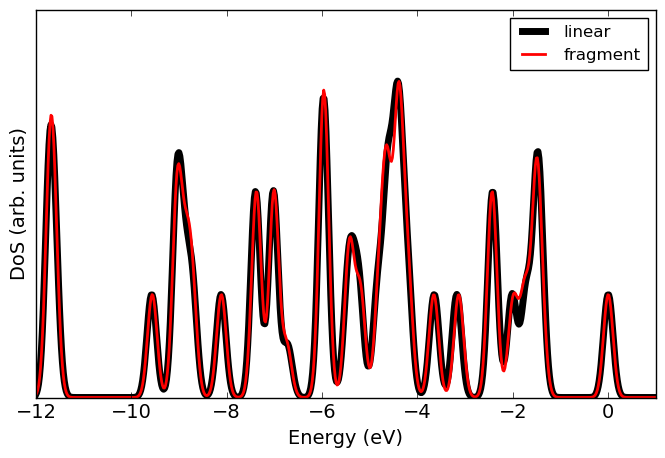

In [17]:
plt.show()

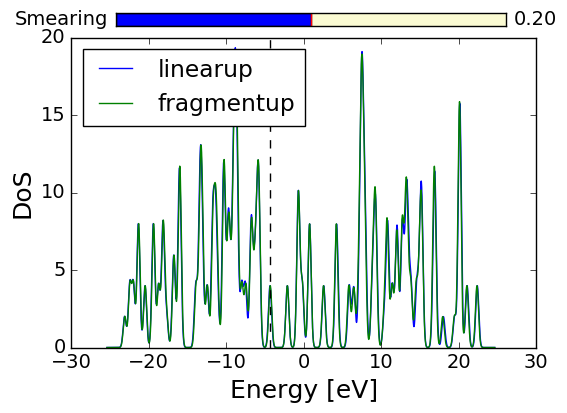

In [31]:
dos=data['logfiles'][0].get_dos(label='linear')
dos.append_from_bandarray(data['logfiles'][1].evals,label='fragment')
dos.fermi_level(fermi_level=data['fermi'][0]) #the method to align different fermi level should still be added
dos.plot()